Description:  This script produces Figure 9 (time-height plots of (i) VHF source density, and (ii) Flash initiation density)

In [1]:
import glob
import os
import warnings
from datetime import datetime

import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import netCDF4 as ncdf
import numpy as np
import pandas as pd
import pyart
import xarray as xr

from lmatools.vis.multiples_nc import centers_to_edges
from may19_2013_obs_analysis.lma_parsing import ceil, sec2time, bbox_lma_data 

xr.set_options(display_style="html")

warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 15
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 2


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [3]:
# subset flash source density and initiation dataset and limit region within bounding box of EC storm

source_dir = os.path.expanduser("../data/processed/gridded_lma_files_3d_10min_int/")

ncnames_den = sorted(glob.glob(source_dir + "/src_den/*source_3d.nc"))
ncnames_ini = sorted(glob.glob(source_dir + "/flash_init/*flash_init_3d.nc"))

# spatial filtering of data for lma source density and flash initiations
# this is to ensure that we are confined to EC storm at all times for analysis purposes
datasets_den = []
datasets_ini = []
ll_lon = []
ul_lon = []
ll_lat = []
ul_lat = []

for i in range(len(ncnames_ini)):

    fden = ncnames_den[i]
    fini = ncnames_ini[i]

    data_den = xr.open_dataset(fden)
    data_ini = xr.open_dataset(fini)

    data_den = data_den.assign_coords(
        alt=data_den.altitude,
        lat=data_den.latitude,
        lon=data_den.longitude,
        ntimes=data_den.time,
    )

    data_ini = data_ini.assign_coords(
        alt=data_ini.altitude,
        lat=data_ini.latitude,
        lon=data_ini.longitude,
        ntimes=data_ini.time,
    )

    # using time string in names of density files as threshold to obtain the correct bounding limits
    # of Edmond-Carney storm. We could have used fini as well since both files contain same time strings.

    parts = fden.split("/")

    ll_lon, ul_lon, ll_lat, ul_lat = bbox_lma_data(int(parts[-1].split("_")[2]))

    # Applying bounding box limits to source density and flahs initiation datasets
    # to avoid counting data from regions outside the periphery of EC storm.

    source_data = data_den["lma_source"].where(
        (data_den.longitude > ll_lon)
        & (data_den.longitude < ul_lon)
        & (data_den.latitude > ll_lat)
        & (data_den.latitude < ul_lat)
    )

    time_height_source = source_data[:, :, :, :].sum(dim=["lat", "lon"]).T
    datasets_den.append(time_height_source)

    # Similarly, apply bounding box limits to flash initiation data
    initiation_data = data_ini["flash_initiation"].where(
        (data_ini.longitude > ll_lon)
        & (data_ini.longitude < ul_lon)
        & (data_ini.latitude > ll_lat)
        & (data_ini.latitude < ul_lat)
    )

    time_height_initiation = initiation_data[:, :, :, :].sum(dim=["lat", "lon"]).T
    datasets_ini.append(time_height_initiation)

    del data_den, data_ini

In [4]:
# load filtered CG data (CGs with peak current magnitude less than
# 15 kA and outside EC storm territory have been removed )
file  = '../data/interim/filtered_NLDN_15kA_only_within_EC_storm_for_pandas.txt'
cg_data = pd.read_csv(file, sep=",")

pos_cg = cg_data[cg_data["Power"] > 0]
neg_cg = cg_data[cg_data["Power"] < 0]

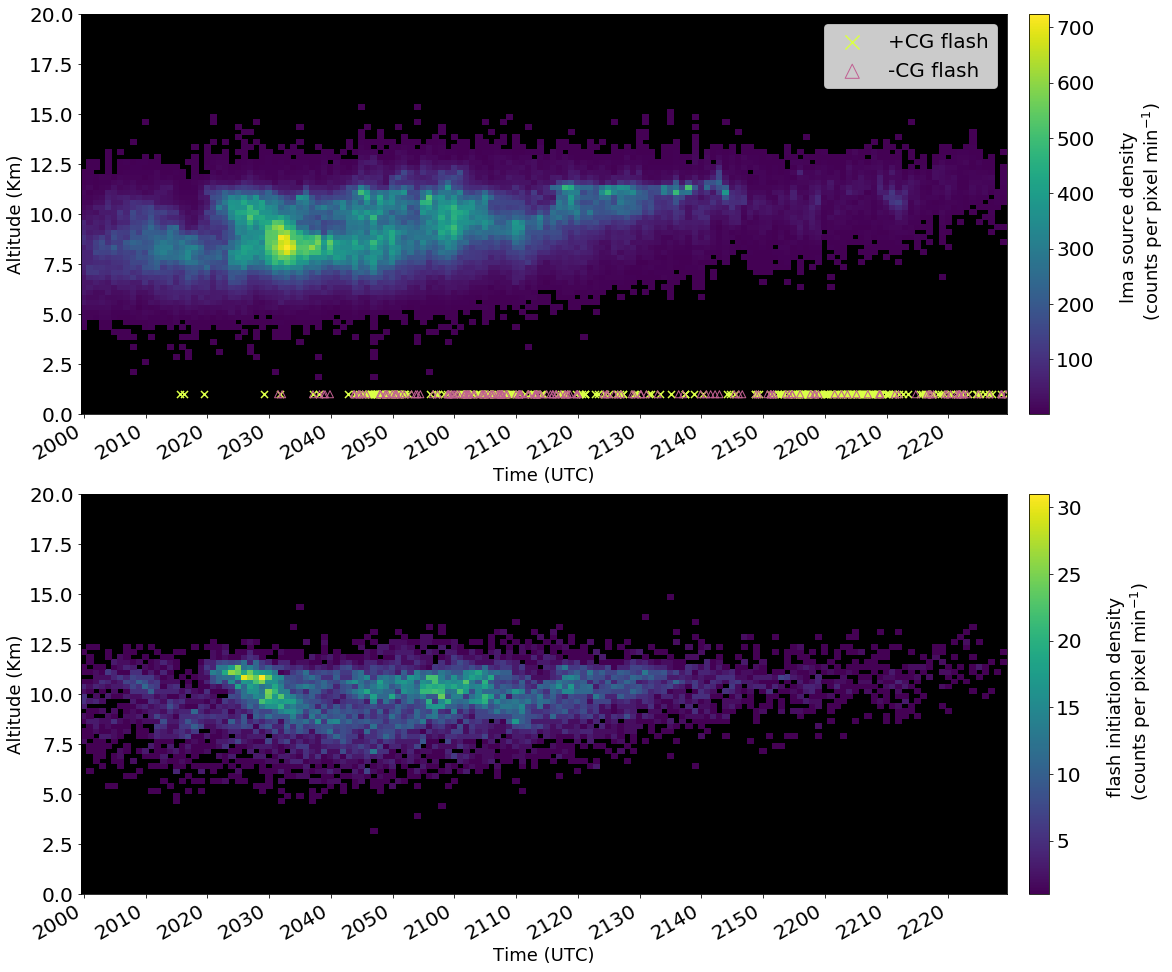

In [5]:
# Plot the filtered source density and flash initiation data
fig = plt.figure(figsize=(20, 25))
ax1 = fig.add_subplot(311)
combined_den = xr.concat(datasets_den, dim="ntimes")
combined_den = combined_den.where(combined_den.data > 0)
combined_den.data = combined_den.data
combined_den["alt"] = combined_den["alt"] / 1000
pl_den = combined_den.plot(ax=ax1, cmap="viridis", add_colorbar=False)

ax1.scatter(
    pos_cg["datetime"],
    np.ones_like(pos_cg["datetime"]),
    marker="x",
    c="#DAFF47",
    s=50,
    label="+CG flash",
)
ax1.scatter(
    neg_cg["datetime"],
    np.ones_like(neg_cg["datetime"]),
    marker="^",
    facecolors="none",
    edgecolors="#C16092",
    s=50,
    label="-CG flash",
)
ax1.set_facecolor("black")

ax2 = fig.add_subplot(312)
combined_ini = xr.concat(datasets_ini, dim="ntimes")
combined_ini = combined_ini.where(combined_ini.data > 0)
combined_ini.data = combined_ini.data
combined_ini["alt"] = combined_ini["alt"] / 1000
pl_ini = combined_ini.plot(ax=ax2, cmap="viridis", add_colorbar=False)
ax2.set_facecolor("black")


ax1.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
# plt.xticks(rotation=0)
ax1.set_ylabel("Altitude (Km)")
ax1.set_xlabel("Time (UTC)")
cbar1 = plt.colorbar(pl_den, pad=0.02, ax=ax1)
cbar1.set_label("lma source density \n (counts per pixel min$^{-1}$)", labelpad=25)

ax2.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
# plt.xticks(rotation=0)
ax2.set_ylabel("Altitude (Km)")
ax2.set_xlabel("Time (UTC)")
cbar2 = plt.colorbar(pl_ini, pad=0.02, ax=ax2)
cbar2.set_label(
    "flash initiation density \n (counts per pixel min$^{-1}$)", labelpad=25
)


# plt.tight_layout()
ax1.legend(loc="best")
# plt.savefig(os.path.expanduser(
#     '~/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/time_alt_improved.png'), bbox_inches='tight', dpi=300)
plt.show()

Trial using xarray and dask chunks

It works but is too slow

In [ ]:
source_dir = os.path.expanduser("./data_files/gridded_lma_files_3d_10min_int/")

ncnames_den = sorted(glob.glob(source_dir + "/src_den/*source_3d.nc"))
ncnames_ini = sorted(glob.glob(source_dir + "/flash_init/*flash_init_3d.nc"))
data_mega = xr.open_mfdataset(ncnames_den, concat_dim="ntimes", combine="nested")

dataset_mega = []
t = 0
for i in range(len(ncnames_den)):
    parts = ncnames_den[i]
    ll_lon, ul_lon, ll_lat, ul_lat = bbox_lma_data(
        int(parts.split("/")[-1].split("_")[2])
    )
    data = data_mega.isel(ntimes=slice(t, t + 10))
    dataset_mega.append(
        data.lma_source.where(
            (data.longitude > ll_lon)
            & (data.longitude < ul_lon)
            & (data.latitude > ll_lat)
            & (data.latitude < ul_lat)
        )
    )
    t += 10

ff = xr.concat(dataset_mega, dim="ntimes")

tt = ff.sum(dim=["lon", "lat"])
tt = tt.assign_coords(
    {
        "alt": data["altitude"].isel(ntimes=0).compute(),
        "ntimes": data_mega.time.compute(),
    }
)

tt.T.plot()

In [ ]:
combined_ini = xr.concat(datasets_ini, dim="ntimes")
combined_ini = combined_ini.where(combined_ini.data > 0)

In [ ]:
combined_ini["alt"] = combined_ini["alt"] / 1000
pl_ini = combined_ini.plot(
    cmap="cubehelix_r", add_colorbar=True, norm=matplotlib.colors.LogNorm()
)

In [ ]:
np.exp(6)

In [ ]:
combined_den = xr.concat(datasets_den, dim="ntimes")
combined_den = combined_den.where(combined_den > 0, drop=True)
# combined_den = combined_den.where(combined_den.data > 0)
fig = plt.figure(figsize=(20, 8))
combined_den.plot()

In [ ]:
combined_den.data = np.log(combined_den.data)
combined_den["alt"] = combined_den["alt"] / 1000
fig = plt.figure(figsize=(20, 8))
combined_den.plot()

In [ ]:
combined_ini = xr.concat(datasets_ini, dim="ntimes")
# combined_ini = combined_ini.where(combined_ini.data > 0)
combined_ini = combined_ini.where(combined_ini > 0, drop=True)
fig = plt.figure(figsize=(20, 8))
combined_ini.plot()

In [ ]:
combined_ini.data = np.log(combined_ini.data)
combined_ini["alt"] = combined_ini["alt"] / 1000
fig = plt.figure(figsize=(20, 8))
combined_ini.plot()

#### xarray map_blocks approach (unsuccessful so far)

In [4]:
source_dir = os.path.expanduser("./data_files/gridded_lma_files_3d_10min_int/")

ncnames_den = sorted(glob.glob(source_dir + "/src_den/*source_3d.nc"))
ncnames_ini = sorted(glob.glob(source_dir + "/flash_init/*flash_init_3d.nc"))

# spatial filtering of data for lma source density and flash initiations
# this is to ensure that we are confined to EC storm at all times for analysis purposes
datasets_den = []
datasets_ini = []
ll_lon = []
ul_lon = []
ll_lat = []
ul_lat = []

data_den = xr.open_mfdataset(ncnames_den, concat_dim="ntimes", combine="nested")
data_den = data_den.set_coords(["latitude", "longitude", "altitude"])

final = data_den.chunk({"ntimes": 10})


dts = pd.date_range(start="2013-05-19 20:00:00", end="2013-05-19 22:29:00", freq="1T")
dtsnp = [x.to_datetime64().astype("datetime64[s]") for x in dts]

ll_lons = np.repeat(
    [
        -98.1,
        -98,
        -98,
        -97.9,
        -97.8,
        -97.75,
        -97.8,
        -97.7,
        -97.6,
        -97.6,
        -97.5,
        -97.4,
        -97.15,
        -97.25,
        -97,
    ],
    len(dts) / len(ncnames_den),
)
ul_lons = np.repeat(
    [
        -97.6,
        -97.3,
        -97.3,
        -97.2,
        -97.1,
        -97.1,
        -97,
        -96.8,
        -96.8,
        -96.8,
        -96.6,
        -96.6,
        -96.6,
        -96.75,
        -96.5,
    ],
    len(dts) / len(ncnames_den),
)
ll_lats = np.repeat(
    [
        35.35,
        35.35,
        35.35,
        35.4,
        35.4,
        35.45,
        35.4,
        35.5,
        35.5,
        35.5,
        35.5,
        35.55,
        35.62,
        35.63,
        35.62,
    ],
    len(dts) / 10,
)
ul_lats = np.repeat(
    [35.8, 35.8, 35.8, 35.9, 36, 36, 36, 36, 36, 36.1, 36.2, 36.1, 36.1, 36.1, 36.1],
    len(dts) / 10,
)

tt = zip(ll_lons, ul_lons, ll_lats, ul_lats)
tt = list(tt)

limits = dict()
for i in range(len(dts)):
    limits[dtsnp[i]] = tt[i]


def get_lma_data(lma_source: xr.DataArray, limits):
    t = lma_source.time.values.astype("datetime64[s]")
    ll_lon, ul_lon, ll_lat, ul_lat = limits[t]
    data = lma_source.where(
        (lma_source.longitude > ll_lon)
        & (lma_source.longitude < ul_lon)
        & (lma_source.latitude > ll_lat)
        & (lma_source.latitude < ul_lat)
    )
    return data.sum(dim=["lon", "lat"])


mapped = lma_source.chunk({"ntimes": 1}).map_blocks(get_lma_data, args=[limits])